<a href="https://colab.research.google.com/github/sabethasheenu/Movie--Audience-Rating-/blob/main/Audience_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Audience Rating Using Machine Learning

## Problem Statement:
The goal is to build a model that predicts the `audience_rating` for movies based on various features. This notebook demonstrates a complete **machine learning pipeline** that:
1. Cleans and preprocesses the dataset.
2. Builds and trains a regression model.
3. Validates and evaluates the model for accuracy.
4. Provides actionable insights from the results.

## Dataset Overview:
- Source: Rotten Tomatoes Movies Dataset
- Target Column: `audience_rating`
- Features: Mix of numerical and categorical columns.


##Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

##Reading the Dataset
Reading the dataset. Specifying 'latin-1' encoding to handle potential special characters like the copyright symbol which caused a UnicodeDecodeError when using the default 'utf-8'.

In [2]:
data = pd.read_csv("Rotten_Tomatoes_Movies3csv.csv", encoding='latin1')
data.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",12-02-2010,29-06-2010,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",30-04-2010,19-10-2010,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",05-10-1979,27-08-1997,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",13-04-1957,06-03-2001,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",01-01-1954,20-05-2003,127.0,Disney,Fresh,89,27,74.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_title         16638 non-null  object 
 1   movie_info          16614 non-null  object 
 2   critics_consensus   8309 non-null   object 
 3   rating              16638 non-null  object 
 4   genre               16621 non-null  object 
 5   directors           16524 non-null  object 
 6   writers             15289 non-null  object 
 7   cast                16354 non-null  object 
 8   in_theaters_date    15823 non-null  object 
 9   on_streaming_date   16636 non-null  object 
 10  runtime_in_minutes  16483 non-null  float64
 11  studio_name         16222 non-null  object 
 12  tomatometer_status  16638 non-null  object 
 13  tomatometer_rating  16638 non-null  int64  
 14  tomatometer_count   16638 non-null  int64  
 15  audience_rating     16386 non-null  float64
dtypes: f

## 3. Define Features and Target
 Separate the target column 'audience_rating' from the features.
 This is done because the target variable is what we want to predict,
 and it should not be included in the input features used to train the model.

In [4]:
X = data.drop(columns=['audience_rating'])
y = data['audience_rating']

## 2. Cleaning and Exploring the Data Thoroughly

In [5]:
# ## 4. Identify Numerical and Categorical Features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: Index(['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count'], dtype='object')
Categorical Features: Index(['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre',
       'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'studio_name', 'tomatometer_status'],
      dtype='object')


In [6]:
print(data.isnull().sum())

movie_title              0
movie_info              24
critics_consensus     8329
rating                   0
genre                   17
directors              114
writers               1349
cast                   284
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
studio_name            416
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
audience_rating        252
dtype: int64


In [7]:
## Since we do not have null value in most of numerical dataset of X, filling the missing value in y alone
y = y.fillna(y.mean())

## 5. Preprocessing Steps
 Preprocessor to scale numerical features and encode categorical features
 Create a preprocessing pipeline using ColumnTransformer.
*   This applies different preprocessing steps to numerical and categorical features separately.
*  Numerical features are scaled using StandardScaler to have zero mean and unit variance.
* Categorical features are one-hot encoded using OneHotEncoder to convert them into numerical representations.
*  handle_unknown='ignore' - This is used to handle any unseen categories during testing.

This ensures that the model can handle both types of features effectively.

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with the mean
            ('scaler', StandardScaler())]), numerical_features),
       ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Impute with "Missing"
            ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

## Build the Machine Learning Pipeline
Comparing three different regression models to find the best fit for the data:
1. **Random Forest:** A robust, non-linear model that can handle complex relationships and is less prone to overfitting.
2. **Linear Regression:** A simple, interpretable model that assumes a linear relationship between features and target.
3. **Gradient Boosting:** Another powerful model that combines weak learners to create a strong predictive model.

By comparing their performance using metrics like MSE and R2, we can identify the most suitable model for predicting audience ratings.

In [9]:
# Defining the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [10]:
 #  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_train.mean())

In [11]:
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")  # Print before training
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    print(f"{model_name} trained.")  # Print after training
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2}

print("\nAll models trained.")

Training Random Forest...
Random Forest trained.
Training Linear Regression...
Linear Regression trained.
Training Gradient Boosting...
Gradient Boosting trained.

All models trained.


## Evaluating the Models and Visualization
**MSE** measures the average squared difference between actual and predicted values.Lower MSE indicates better model performance.

**R2** represents the proportion of variance in the target variable explained by the model.Higher R2 indicates a better fit, with 1 being a perfect fit.

In [13]:
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  R2: {metrics['R2']:.2f}")


Model Performance:
Random Forest:
  MSE: 211.95
  R2: 0.48
Linear Regression:
  MSE: 194.57
  R2: 0.52
Gradient Boosting:
  MSE: 202.99
  R2: 0.50


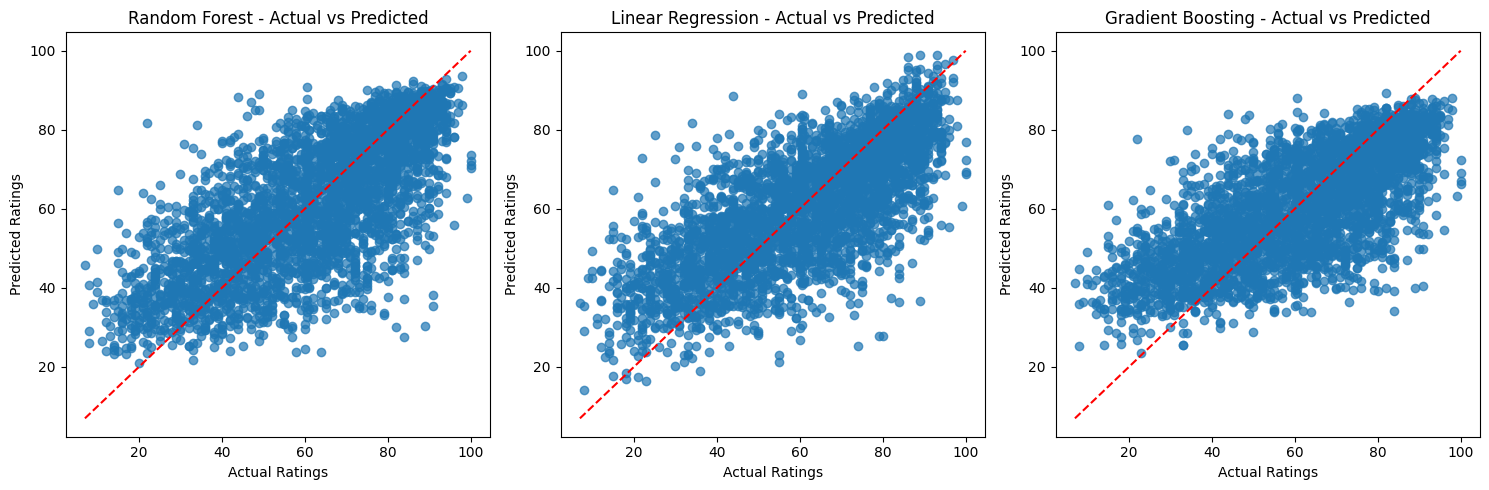

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, model_name in enumerate(models):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', models[model_name])
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    axes[i].scatter(y_test, y_pred, alpha=0.7)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
    axes[i].set_xlabel("Actual Ratings")
    axes[i].set_ylabel("Predicted Ratings")
    axes[i].set_title(f"{model_name} - Actual vs Predicted")

plt.tight_layout()
plt.show()

In [17]:
for model_name in results:
    results[model_name]['Combined_Score'] = results[model_name]['R2'] - results[model_name]['MSE']
best_fit = max(results, key=lambda model: results[model]['Combined_Score'])

print(f"\nThe best fit all three is {best_fit}.")


The best fit all three is Linear Regression.


##Summary
This notebook presented a machine learning pipeline for predicting movie **audience ratings** using the Rotten Tomatoes Movies Dataset. Here I explored data cleaning, preprocessing techniques (scaling and encoding), and compared three regression models: Random Forest, Linear Regression, and Gradient Boosting. Model evaluation using MSE and R2 scores revealed that **Linear Regression** provided the best fit, as indicated by its higher R2 and lower MSE scores. Overall, the project demonstrates a successful application of machine learning to predict audience ratings, offering valuable insights for understanding factors influencing movie reception.